In [1]:
!pip uninstall tensorflow -y
!pip install tensorflow==2.15.0

Found existing installation: tensorflow 2.17.0
Uninstalling tensorflow-2.17.0:
  Successfully uninstalled tensorflow-2.17.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 109.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.6 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.0
    Uninstalling ml-dtypes-0.4.0:
      Successfully uninstalled ml-dtypes-0.4.0
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstallin

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

import tensorflow as tf
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.layers import Dropout

In [2]:
print(tf.__version__)

2.15.0


In [35]:
from google.colab import drive
drive.mount('/content/drive')

# Set the path to your dataset and CSV file
image_dir = '/content/drive/MyDrive/solar_dataset/images/images/'  # Folder with solar panel images
csv_file = '/content/drive/MyDrive/solar_dataset/Voc_Values.csv'  # CSV with image paths and voltage values



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [66]:
import pandas as pd

# Load the CSV file
df = pd.read_csv(csv_file)

# Inspect the DataFrame
print(df.head())

# Example DataFrame:
#        image_path      open_voltage
# 0    img1.jpg              22.5
# 1    img2.jpg              23.0
# 2    img3.jpg              21.8


             image_path  Voltage
0  _20240902_131710.jpg   0.1313
1  _20240902_132551.jpg   0.1419
2  _20240902_133406.jpg   0.1269
3  _20240902_134318.jpg   0.1349
4  _20240902_135230.jpg   0.1459


0.1313

In [37]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Function to preprocess images and return them with their corresponding voltage
class SolarImageDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataframe, batch_size, image_dir, target_size=(224, 224), shuffle=True):
        self.dataframe = dataframe
        self.batch_size = batch_size
        self.image_dir = image_dir
        self.target_size = target_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return len(self.dataframe) // self.batch_size

    def __getitem__(self, index):
        # Generate indices of the batch
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]

        # Get the images and labels for the batch
        batch_df = self.dataframe.iloc[batch_indices]
        images = np.array([self.load_image(img_path) for img_path in batch_df['image_path']])
        labels = batch_df['Voltage'].values

        return images, labels

    def on_epoch_end(self):
        # Shuffle the data at the end of each epoch if required
        self.indices = np.arange(len(self.dataframe))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def load_image(self, img_path):
        # Load and preprocess the image
        img = load_img(self.image_dir + img_path, target_size=self.target_size)
        img = img_to_array(img)
        img /= 255.0  # Normalize pixel values to [0, 1]
        return img




In [47]:
# Example usage
batch_size = 16
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)  # Split the dataset

train_generator = SolarImageDataGenerator(train_df, batch_size=batch_size, image_dir=image_dir)
val_generator = SolarImageDataGenerator(val_df, batch_size=batch_size, image_dir=image_dir)

In [48]:
optimizer = Adam(learning_rate=1e-4, clipvalue=1.0)  # Clip gradients to a maximum value

In [50]:
# Load ResNet50 or EfficientNet as the base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224,3))
#base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Build the full model for regression
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='linear')  # Output a single continuous value (voltage)
])
# Check model layers and their shapes
#model.add(Dense(128, activation='relu', kernel_initializer=HeNormal()))
#model.add(Dropout(0.5))  # Add dropout layer to reduce overfitting

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Print model summary
model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_7  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_18 (Dropout)        (None, 2048)              0         
                                                                 
 dense_18 (Dense)            (None, 128)               262272    
                                                                 
 dropout_19 (Dropout)        (None, 128)               0         
                                                                 
 dense_19 (Dense)            (None, 1)                 129       
                                                      

In [51]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,  # Adjust the number of epochs as necessary
    verbose=1
)


Epoch 1/10
13/13 [==============================] - 48s 3s/step - loss: 1.0404 - mae: 0.8012 - val_loss: 0.3410 - val_mae: 0.5830
Epoch 2/10
13/13 [==============================] - 41s 3s/step - loss: 0.5729 - mae: 0.6083 - val_loss: 0.2489 - val_mae: 0.4979
Epoch 3/10
13/13 [==============================] - 43s 3s/step - loss: 0.5209 - mae: 0.5958 - val_loss: 0.1095 - val_mae: 0.3289
Epoch 4/10
13/13 [==============================] - 43s 3s/step - loss: 0.4616 - mae: 0.5389 - val_loss: 0.0799 - val_mae: 0.2804
Epoch 5/10
13/13 [==============================] - 42s 3s/step - loss: 0.4212 - mae: 0.5065 - val_loss: 0.0937 - val_mae: 0.3042
Epoch 6/10
13/13 [==============================] - 40s 3s/step - loss: 0.4479 - mae: 0.5392 - val_loss: 0.1357 - val_mae: 0.3669
Epoch 7/10
13/13 [==============================] - 44s 3s/step - loss: 0.4216 - mae: 0.5175 - val_loss: 0.1641 - val_mae: 0.4039
Epoch 8/10
13/13 [==============================] - 43s 3s/step - loss: 0.2992 - mae: 0.44

In [52]:
# Evaluate the model on validation data
val_loss, val_mae = model.evaluate(val_generator)
print(f'Validation MAE: {val_mae}')

# Save the trained model
model.save('/content/drive/MyDrive/solar_voltage_regression_model.h5')


3/3 [==============================] - 6s 2s/step - loss: 0.0588 - mae: 0.2402
Validation MAE: 0.24022053182125092


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


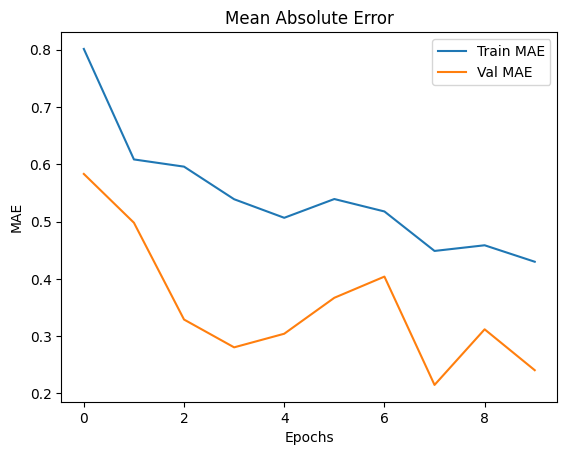

In [53]:
# Plot training & validation loss and MAE
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('Mean Absolute Error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()


1/1 [==============================] - 0s 22ms/step


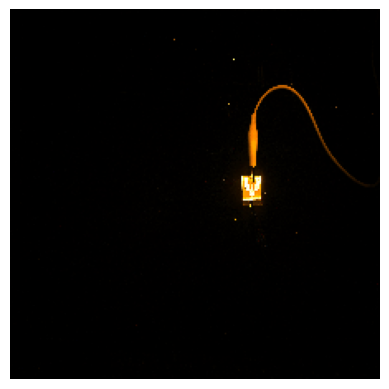

Predicted Output VoC: 1.1519932746887207
Actual Output VoC: 1.1273


<ipython-input-81-89c717093163>:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Predicted Output VoC:', (1+abs(float(predicted_output[0]))))


In [81]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

# Load and preprocess the image
img_path = '/content/drive/MyDrive/solar_dataset/images/images/_20240905_121838.jpg'

# Adjust target_size according to your model's input shape
img = load_img(img_path, target_size=(224, 224))  # For ResNet/EfficientNet models, use (224, 224)
plt.imshow(img)
img = img_to_array(img)  # Convert the image to a numpy array
img = img / 255.0        # Normalize pixel values to [0, 1]
img = np.expand_dims(img, axis=0)  # Add a batch dimension

# Predict using the trained model
predicted_output = model.predict(img)

#img = mpimg.imread(image_path)

plt.axis('off')  # To hide the axis
plt.show()
# Print the output
print('Predicted Output VoC:', (1+abs(float(predicted_output[0]))))
print('Actual Output VoC:', (1+abs(float(df['Voltage'][100]))))

